In [ ]:
!pip install numpy
!pip install matplotlib
!pip install scikit-learn
!pip install paho-mqtt
!pip install scipy

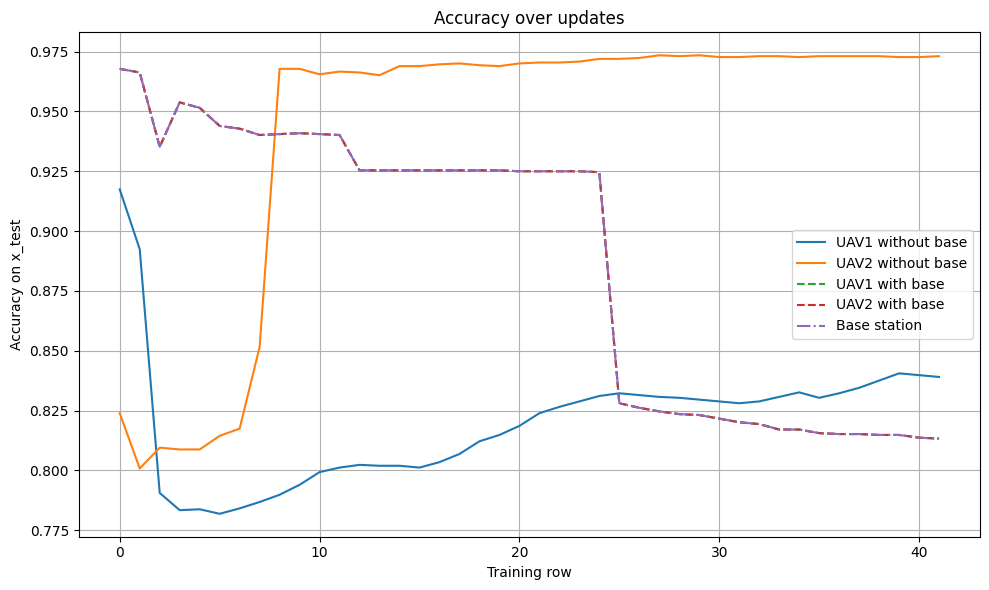

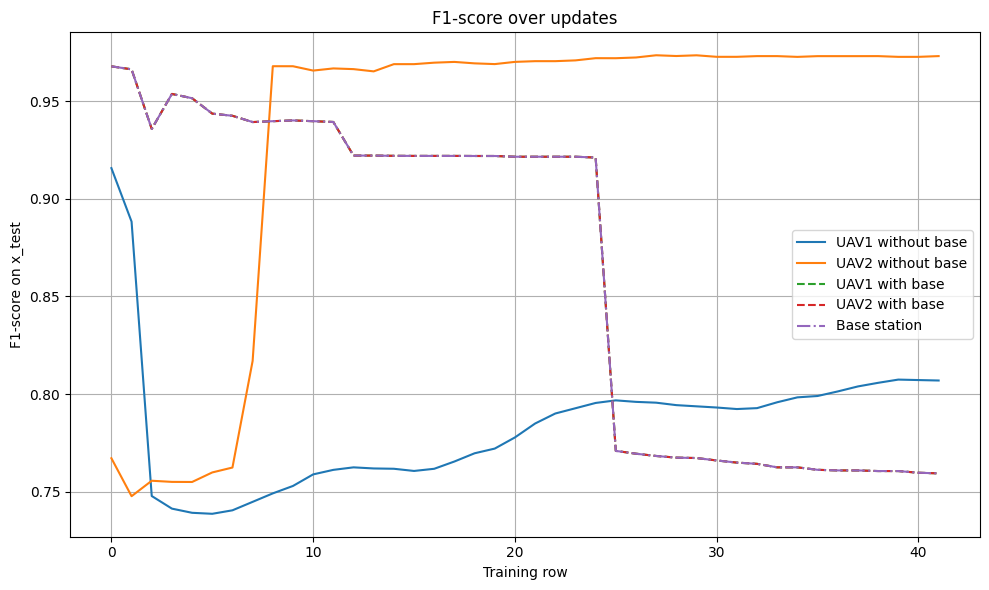

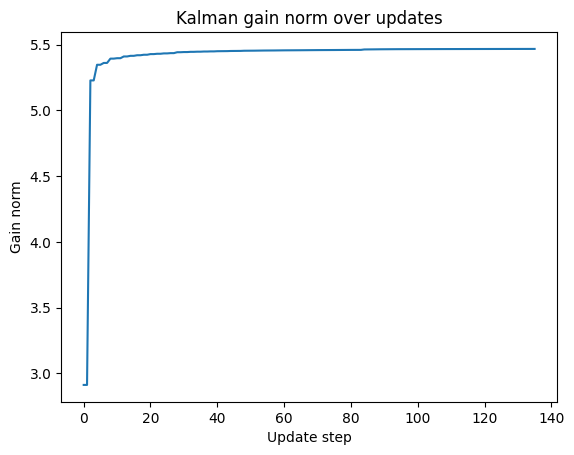

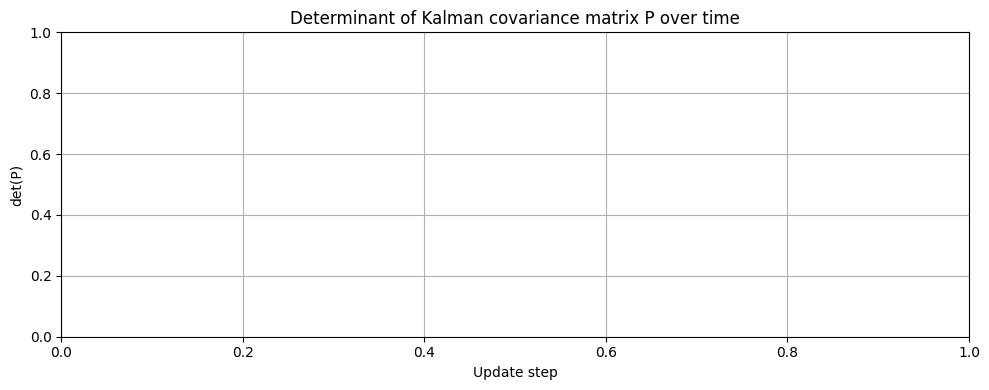

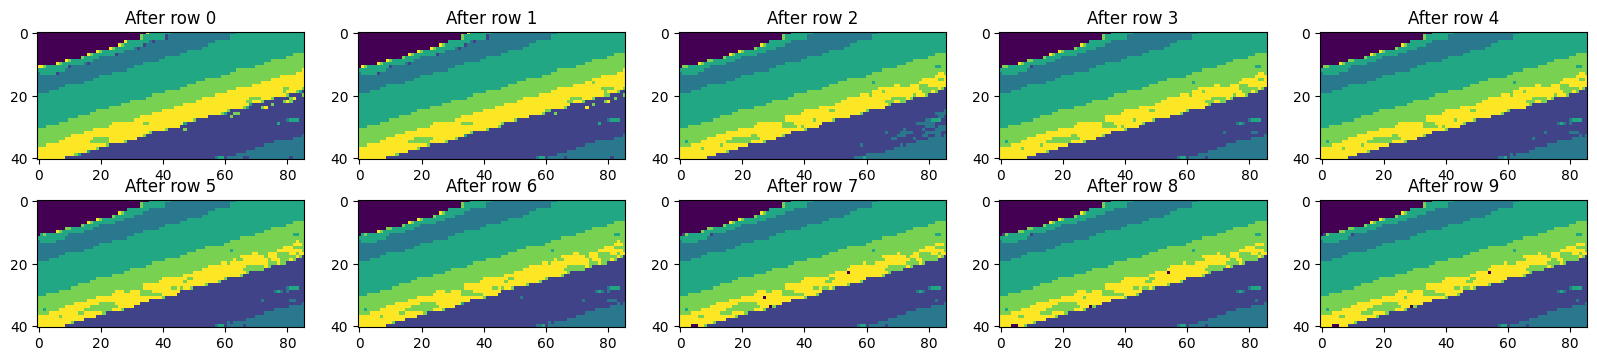

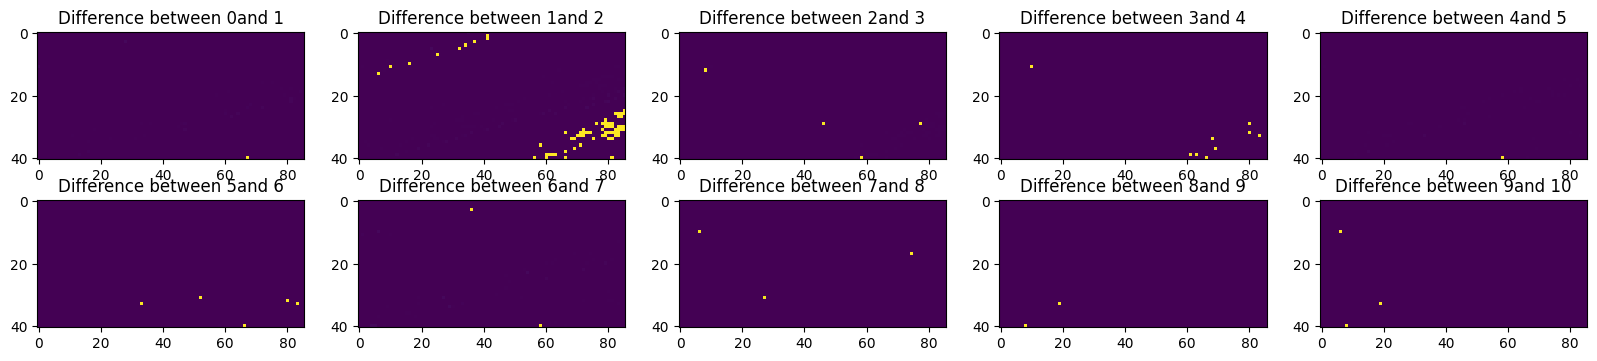

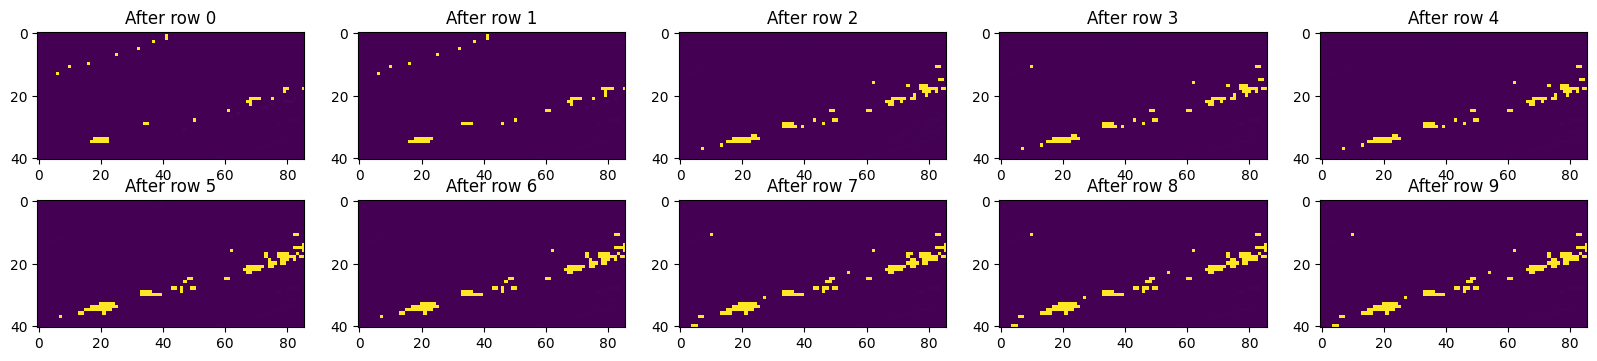

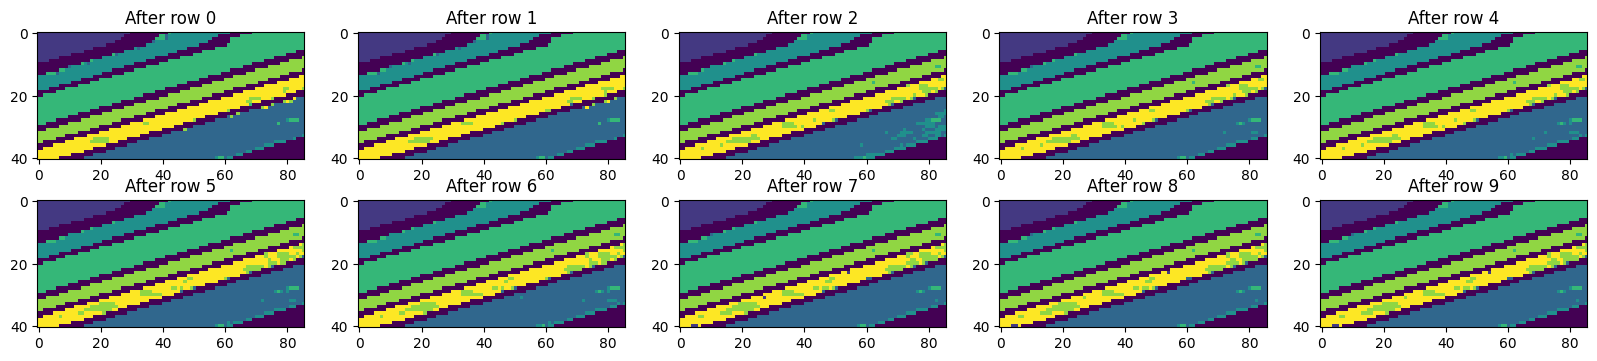

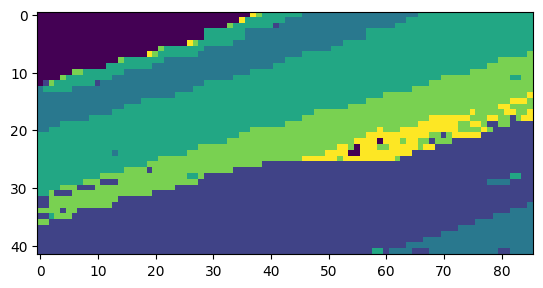

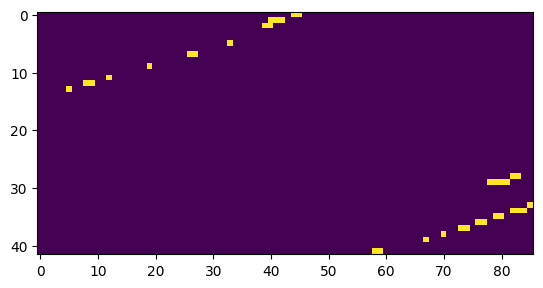

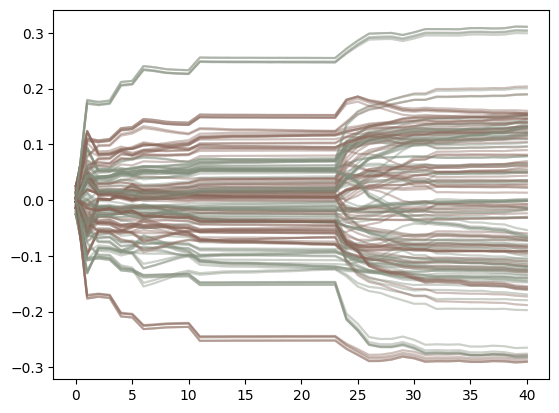

In [ ]:
import sys, os
# assumes this notebook lives in my_project/notebooks/
sys.path.insert(0, os.path.abspath(".."))

import numpy as np
import matplotlib.pyplot as plt
import paho.mqtt.client as mqtt
import threading
##from  src.mlm_functions import  select_R,run_simulation
from  Image_Analyser import  on_message, select_R,run_simulation

MQTT_BROKER = "#IP Adress of the MQTT Host" # <--- TO CHANGE
MQTT_PORT = 1883 # Port used for the MQTT Connexion.
USE_TLS = False

TOPIC_Data = "pi/data"
TOPIC_ACK = "pc/ack"

CHUNK_SIZE = 10_000_000  # Size of the chunks sent over MQTT, in bytes

ack_recu = False
message_id_en_cours = ""
feedback_vars = {}
lock = threading.Lock()

### Launch MQTT Client and subscribe to the feedback topic.
client = mqtt.Client()
client.on_message = on_message
client.connect(MQTT_BROKER, MQTT_PORT, 60)
client.subscribe(TOPIC_ACK)
client.loop_start()

x_test = np.load('/home/palomies/Documents/Proj_Finland/data/salinas_x_test.npy')
x_train = np.load('/home/palomies/Documents/Proj_Finland/data/salinas_x_train.npy')
y_test = np.load('/home/palomies/Documents/Proj_Finland/data/salinas_y_test.npy')
y_train = np.load('/home/palomies/Documents/Proj_Finland/data/salinas_y_train.npy')


##from scipy.io import loadmat
##X = loadmat('/home/palomies/Documents/Proj_Finland/data/Pavia.mat')
##Y = loadmat('/home/palomies/Documents/Proj_Finland/data/Pavia_gt.mat')
##X = np.double(np.array(X['paviaU']))
##Y = np.double(np.array(Y['paviaU_gt']))

##x_test = X[::2,:,:]
##x_train = X[1::2,:,:]
##y_test = Y[::2,:]
##y_train = Y[1::2,:]

labels = np.unique(y_train)


idx=0
for l in labels:
    y_train[y_train==l]=idx
    y_test[y_test==l]=idx
    idx +=1

R, y_R = select_R(x_train, y_train, n_per_class=5, random_seed=10)



uav1_rows = x_train[:,0:int(x_train.shape[1]/2),:]
uav2_rows = x_train[:,int(x_train.shape[1]/2)::,]

# Run simulation
metrics, test_results, train_res, models = run_simulation(x_train, y_train, x_test, y_test, R, y_R, uav1_rows, uav2_rows, 0.94736842, 1.94736842, client)

plt.figure(figsize=(20,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(test_results['base'][i])
    plt.title('After row '+str(i))
plt.show()

plt.figure(figsize=(20,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(test_results['base'][i]-test_results['base'][i+1])
    plt.title('Difference between '+str(i) + 'and '+str(i+1))
plt.show()

plt.figure(figsize=(20,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow((test_results['base'][i]-y_test)*(y_test>0))
    plt.title('After row '+str(i))
plt.show()

plt.figure(figsize=(20,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(test_results['base'][i]*(y_test>0))
    plt.title('After row '+str(i))
plt.show()


plt.imshow(train_res)
plt.show()

plt.imshow((train_res*(y_train>0)-y_train)>0)
plt.show()

mallit = np.zeros((30,30,42))
for i in range(42):
    mallit[:,:,i] = models['base'][i]

for i in range(30):
    for j in range(30):
        plt.plot(mallit[i,j,0::-1]-mallit[i,j,1::],alpha=0.1)
        

plt.show()
client.loop_stop()
client.disconnect()
        

In [ ]:
# Hyperparameter optimization

upper = np.linspace(1,2,20)
lower = np.linspace(0,1,20)

acc_table = np.zeros((20,20))
f1_table =  np.zeros((20,20))

idx = [0,0]

for i in range(0,20):
    for j in range(0,20) :
        metrics, test_results, train_res, models= run_simulation(x_train, y_train, x_train, y_train, R, y_R, uav1_rows, uav2_rows, lower[j], upper[i])
        acc_table[i,j] = metrics['base']['acc'][41]
        f1_table[i,j] = metrics['base']['f1'][41]

plt.imshow(acc_table)
plt.show()
plt.imshow(f1_table)
plt.show()

print(np.max(acc_table))
print(np.argmax(acc_table))

In [ ]:
plt.imshow(acc_table)
plt.colorbar()
plt.show()
plt.imshow(f1_table)
plt.colorbar()
plt.show()

print(np.max(acc_table))
print(np.where(acc_table==np.max(acc_table)))
print('up' + str(upper[np.where(acc_table==np.max(acc_table))[1]]))
print('low' + str(lower[np.where(acc_table==np.max(acc_table))[1]]))



In [ ]:
lower

In [ ]:
plt.figure(figsize=(10,6))
plt.imshow(x_train[:,:,[35,20,1]]**0.5)
plt.show()
plt.figure(figsize=(10,6))
plt.imshow(x_train[:,:,[50,60,85]])
plt.show()
plt.plot(x_train[30,30,:])
plt.plot(x_train[35,40,:])
plt.plot(x_train[40,50,:])

plt.show()


In [ ]:

mallit = np.zeros((30,30,42))
for i in range(42):
    mallit[:,:,i] = models['base'][i]

for i in range(30):
    for j in range(30):
        plt.plot(mallit[i,j,0::-1]-mallit[i,j,1::],alpha=0.1)
        plt.xlabel('Training row')
        plt.ylabel('Model $B$ weights')
        

plt.show()


In [ ]:
len(test_results['base'])

In [ ]:
# plt.figure(figsize=(20,20),dpi=300)
# for i in range(20):
#     plt.subplot(4,5,i+1)
#     plt.imshow(test_results['base'][i]*(y_test>0),cmap='jet')
#     plt.colorbar()
#     plt.title('After row '+str(i))
# plt.show()
plt.figure(dpi=300)
plt.subplot(1,2,1)
plt.imshow(test_results['base'][int(len(test_results['base']))-1]*(y_test>0),cmap='jet')
plt.subplot(1,2,2)
plt.imshow(y_test,cmap='jet')
plt.show()

In [ ]:
plt.figure(figsize=(20,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(test_results['base'][i])
    plt.title('After row '+str(i))
plt.show()

plt.figure(figsize=(20,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(test_results['base'][i]-test_results['base'][i+1])
    plt.title('Difference between '+str(i) + 'and '+str(i+1))
plt.show()

plt.figure(figsize=(20,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow((test_results['base'][i]-y_test)*(y_test>0))
    plt.title('After row '+str(i))
plt.show()

plt.figure(figsize=(20,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(test_results['base'][i]*(y_test>0))
    plt.title('After row '+str(i))
plt.show()


plt.imshow(train_res)
plt.show()

plt.imshow((train_res*(y_train>0)-y_train)>0)
plt.show()



In [ ]:
from scipy.io import loadmat
X = loadmat('Pavia.mat')
Y = loadmat('Pavia_gt.mat')
X =np.array(X['paviaU'])
Y = np.array(Y['paviaU_gt'])

x_test = X[::2,:,:]
x_train = X[1::2,:,:]
y_test = Y[::2,:]
y_train = Y[1::2,:]

In [ ]:
X.shape